# Initial Setup

In [0]:
! ls
% cd
% cd /content
! rm -rf octopath
! ls

get_datasets.sh  knn.py		   __pycache__	svm.py
ilib		 lr_classifier.py  softmax.py
/root
/content
cifar-10-batches-py  sample_data


In [0]:
# Import the code.
! git clone https://bitbucket.org/EverWinter23/octopath

# List directories
! ls

# Change working directory
% cd octopath

# Download the CIFAR-10 dataset
#! ./get_datasets.sh

Cloning into 'octopath'...
remote: Counting objects: 91, done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 91 (delta 42), reused 0 (delta 0)
Unpacking objects: 100% (91/91), done.
cifar-10-batches-py  octopath  sample_data
/content/octopath


# k-Nearest Neighbor (kNN)


In [0]:
# run setup code for this notebook.
import matplotlib.pyplot as plt

%matplotlib inline

# set default size of plots
plt.rcParams['figure.figsize'] = (10.0, 8.0)

%load_ext autoreload
%autoreload 2

In [0]:
import numpy as np
from ilib.data_utils import load_dataset

# Load the raw CIFAR-10 data.
root_dir = '/content/cifar-10-batches-py'
X_train, Y_train, X_test, Y_test = load_dataset(root_dir)

# size of the training and test data.
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


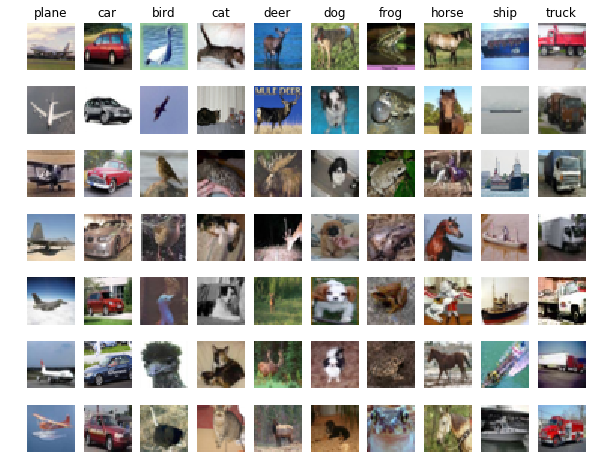

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
n_classes = len(classes)
samples = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Y_train == y)
    idxs = np.random.choice(idxs, samples, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * n_classes + y + 1
        plt.subplot(samples, n_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# subsample the data
n_train = 10000
mask = list(range(n_train))
X_train = X_train[mask]
Y_train = Y_train[mask]

n_test = 1000
mask = list(range(n_test))
X_test = X_test[mask]
Y_test = Y_test[mask]

In [0]:
# reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print(X_train.shape, X_test.shape)

(10000, 3072) (1000, 3072)


In [0]:
from knn import KNN

knn = KNN()
knn.train(X_train, Y_train)

dists = knn.compute_l2_dists(X_test)

# k = 1 means the Nearest Neighbor
Y_test_pred = knn.predict_labels(dists, k=1)

n_correct = np.sum(Y_test_pred == Y_test)
accuracy = float(n_correct) / n_test * 100
print("{} correct out of {}. Accuracy={}%".format(n_correct, n_test, accuracy))

283 correct out of 1000. Accuracy=28.299999999999997


In [0]:
# now, with k=5
Y_test_pred = knn.predict_labels(dists, k=5)

n_correct = np.sum(Y_test_pred == Y_test)
accuracy = float(n_correct) / n_test * 100
print("{} correct out of {}. Accuracy={}%".format(n_correct, n_test, accuracy))

296 correct out of 1000. Accuracy=29.599999999999998


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [0]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds, Y_train_folds = list(), list()

X_train_folds = np.array_split(X_train, num_folds)
Y_train_folds = np.array_split(Y_train, num_folds)

k_to_accuracies = {}

# k-fold validation
for i in range(num_folds):
    # splicing consumes a lot of time
    X_train_batch = np.concatenate(X_train_folds[1:])
    Y_train_batch = np.concatenate(Y_train_folds[1:])
    
    X_valid_batch = X_train_folds[0]
    Y_valid_batch = Y_train_folds[0]
    
    # new validation batch
    if i < num_folds - 2:
        tmp = X_train_folds[i + 1]
        X_train_folds[i + 1] = X_train_folds[0]
        X_train_folds[0] = tmp
        
        tmp = Y_train_folds[i + 1]
        Y_train_folds[i + 1] = Y_train_folds[0]
        Y_train_folds[0] = tmp
    
    model = KNN()
    model.train(X_train_batch, Y_train_batch)
    dists = model.compute_l2_dists(X_valid_batch)
    
    for k in k_choices:
        Y_valid_pred = model.predict_labels(dists, k=k)
        num_correct = np.sum(Y_valid_pred == Y_valid_batch)
        accuracy = float(num_correct) / Y_valid_batch.shape[0] * 100
        
        if i == 0:
            k_to_accuracies[k] = []
        k_to_accuracies[k].append(accuracy)

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print("For k={}, accuracy={}%".format(k, accuracy))

For k=1, accuracy=28.849999999999998
For k=1, accuracy=28.4
For k=1, accuracy=28.249999999999996
For k=1, accuracy=27.450000000000003
For k=1, accuracy=27.450000000000003
For k=3, accuracy=28.749999999999996
For k=3, accuracy=27.400000000000002
For k=3, accuracy=27.85
For k=3, accuracy=26.75
For k=3, accuracy=26.75
For k=5, accuracy=29.45
For k=5, accuracy=28.4
For k=5, accuracy=29.75
For k=5, accuracy=27.500000000000004
For k=5, accuracy=27.500000000000004
For k=8, accuracy=29.849999999999998
For k=8, accuracy=29.599999999999998
For k=8, accuracy=28.4
For k=8, accuracy=27.400000000000002
For k=8, accuracy=27.400000000000002
For k=10, accuracy=30.25
For k=10, accuracy=28.7
For k=10, accuracy=28.4
For k=10, accuracy=26.6
For k=10, accuracy=26.6
For k=12, accuracy=30.45
For k=12, accuracy=29.349999999999998
For k=12, accuracy=28.549999999999997
For k=12, accuracy=26.5
For k=12, accuracy=26.5
For k=15, accuracy=29.4
For k=15, accuracy=29.7
For k=15, accuracy=27.500000000000004
For k=15, a

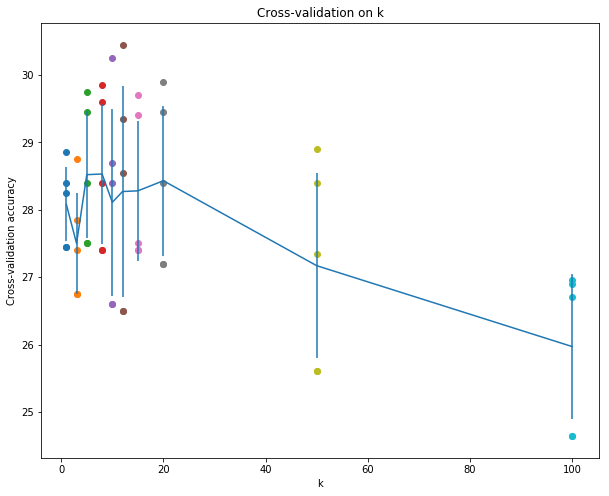

In [0]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [0]:
# based on the cross-validation results above, we choose the one which gives us
# the maximum accuracy
best_k = 10

knn = KNN()
knn.train(X_train, Y_train)
Y_test_pred = knn.predict(X_test, k=best_k)

n_test = X_test.shape[0]

# Compute and display the accuracy
n_correct = np.sum(Y_test_pred == Y_test)
accuracy = float(n_correct) / n_test * 100
print("{} correct out of {}. Accuracy={}%".format(n_correct, n_test, accuracy))

288 correct out of 1000. Accuracy=28.799999999999997


# Multiclass Support Vector Machine


In [0]:
try:
   del X_train, Y_train
   del X_test, Y_test
except:
   pass
  
# load the raw CIFAR-10 data.
root_dir = '/content/cifar-10-batches-py'
X_train, Y_train, X_test, Y_test = load_dataset(root_dir)

# size of the training and test data.
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


In [0]:
n_train = 49000
n_valid = 1000
n_test = 1000
n_devop = 500

# validation set
mask = range(n_train, n_train + n_valid)
X_valid = X_train[mask]
Y_valid = Y_train[mask]

# training set
mask = range(n_train)
X_train = X_train[mask]
Y_train = Y_train[mask]

# development set
mask = np.random.choice(n_train, n_devop, replace=False)
X_devop = X_train[mask]
Y_devop = Y_train[mask]

# test set
mask = range(n_test)
X_test = X_test[mask]
Y_test = Y_test[mask]

# size of the training and test data
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(49000, 32, 32, 3) (49000,) (1000, 32, 32, 3) (1000,)


In [0]:
# reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], -1))
X_devop = np.reshape(X_devop, (X_devop.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# size of the training and test data.
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_devop.shape)

(49000, 3072) (49000,) (1000, 3072) (1000,) (500, 3072)


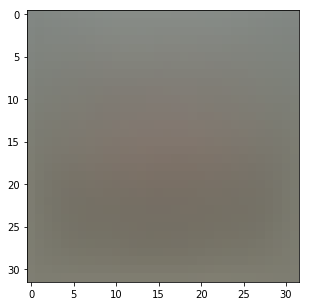

In [0]:
# subtract the mean image
mean_img = np.mean(X_train, axis=0)

 # visualize the mean image
plt.figure(figsize=(5, 5))
plt.imshow(mean_img.reshape((32, 32, 3)).astype('uint8'))
plt.show()

In [0]:
# subtract the mean image from train and test data
X_train -= mean_img
X_valid -= mean_img
X_test -= mean_img
X_devop -= mean_img

In [0]:
# bias trick
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_valid = np.hstack([X_valid, np.ones((X_valid.shape[0], 1))])
X_devop = np.hstack([X_devop, np.ones((X_devop.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_valid.shape, X_test.shape, X_devop.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier


In [0]:
from svm import svm_loss

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss(W, X_devop, Y_devop, 0.000005)
print("loss = {}".format(loss))

loss = 9.024109888266233


### Stochastic Gradient Descent

In [0]:
import time
from lr_classifier import LinearSVM

svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, Y_train, lr=1e-7, rg=2.5e4,
                      n_iters=2000, verbose=True)
toc = time.time()
print("That took {}".format(toc - tic))

iteration 0/2000: loss=411.95737947027794
iteration 100/2000: loss=244.7896993357104
iteration 200/2000: loss=148.0338687134384
iteration 300/2000: loss=91.76110366398481
iteration 400/2000: loss=56.12590389585386
iteration 500/2000: loss=36.753874438876984
iteration 600/2000: loss=24.011664598689997
iteration 700/2000: loss=15.965831275924696
iteration 800/2000: loss=11.545121211260598
iteration 900/2000: loss=9.460673160091599
iteration 1000/2000: loss=7.855128172243269
iteration 1100/2000: loss=6.467860393526007
iteration 1200/2000: loss=6.146868435231735
iteration 1300/2000: loss=6.006346801639212
iteration 1400/2000: loss=5.361862426270477
iteration 1500/2000: loss=5.669987725577731
iteration 1600/2000: loss=5.79508436681528
iteration 1700/2000: loss=4.5292518888350015
iteration 1800/2000: loss=5.695946808796927
iteration 1900/2000: loss=4.753317300395317
That took 11.656964778900146


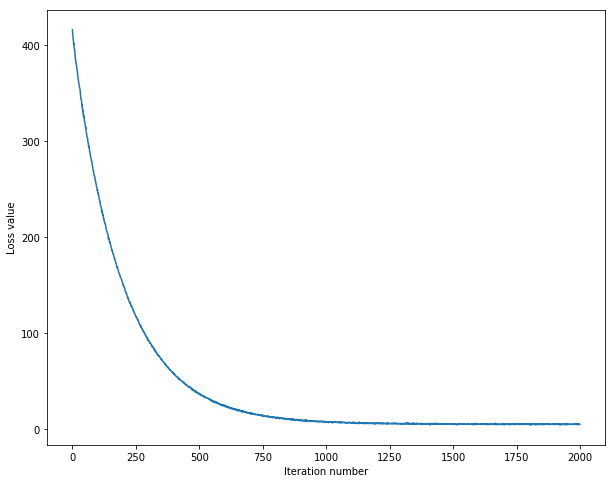

In [0]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [0]:
# evaluate the performance on both the training and validation set

# on training set
Y_train_pred = svm.predict(X_train)
print("training accuracy={}%".format(np.mean(Y_train == Y_train_pred) * 100))

# on validation set
Y_valid_pred = svm.predict(X_valid)
print("validation accuracy={}%".format(np.mean(Y_valid == Y_valid_pred) * 100))

training accuracy=10.026530612244898%
validation accuracy=8.7%


In [0]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The SVM object that achieved the highest validation rate.

for lr in learning_rates:
    for rg in regularization_strengths:
        print("For learning rate={} and regularization strength={}".format(lr, rg))
        svm = LinearSVM()
        loss_hist = svm.train(X_train, Y_train, lr=lr, rg=rg,
                              n_iters=2000, verbose=False)
        Y_train_pred = svm.predict(X_train)
        Y_valid_pred = svm.predict(X_valid)
        
        acc_train = np.mean(Y_train == Y_train_pred)
        acc_valid = np.mean(Y_valid == Y_valid_pred)
        
        results[(lr, rg)] = (acc_train, acc_valid)

        if acc_valid > best_val: 
          best_val = acc_valid
          best_svm = svm
    
# Print out results.
for lr, rg in sorted(results):
    train_acc, valid_acc = results[(lr, rg)]
    print("For[lr={}, rg={}], train_acc={}%, valid_acc={}%".format(lr, rg, train_acc * 100, valid_acc * 100))
   
print("best validation acc={}%".format(best_val * 100))

For learning rate=1e-07 and regularization strength=25000.0
For learning rate=1e-07 and regularization strength=50000.0
For learning rate=5e-05 and regularization strength=25000.0
For learning rate=5e-05 and regularization strength=50000.0


/content/octopath/svm.py:15: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * rg * np.sum(W * W)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/octopath/svm.py:15: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * rg * np.sum(W * W)
/content/octopath/svm.py:10: RuntimeWarning: overflow encountered in subtract
  margins = np.maximum(0, s_c - s_y + 1)
/content/octopath/svm.py:10: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, s_c - s_y + 1)
/content/octopath/svm.py:19: RuntimeWarning: invalid value encountered in greater
  X_mask[margins > 0] = 1
/content/octopath/svm.py:26: RuntimeWarning: overflow encountered in multiply
  dW += rg * W
/content/octopath/lr_classifier.py:30: RuntimeWarning: invalid value encountered in add
  self.W += -lr * grad


For[lr=1e-07, rg=25000.0], train_acc=38.03877551020408%, valid_acc=38.800000000000004%
For[lr=1e-07, rg=50000.0], train_acc=36.997959183673466%, valid_acc=39.4%
For[lr=5e-05, rg=25000.0], train_acc=17.440816326530612%, valid_acc=19.2%
For[lr=5e-05, rg=50000.0], train_acc=10.026530612244898%, valid_acc=8.7%
best validation acc=0.394


In [0]:
# evaluate the best svm on test set
Y_test_pred = best_svm.predict(X_test)
test_acc = np.mean(Y_test == Y_test_pred)

print("SVM test acc={}%".format(test_acc * 100))

SVM test acc=36.199999999999996%


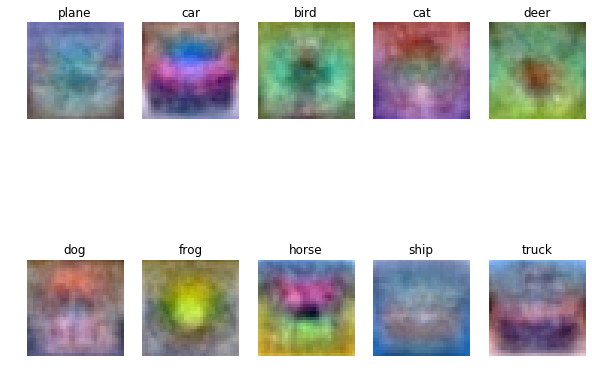

In [0]:
# visualize the learned weights for each class.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i] - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## Softmax Classifier


In [0]:
try:
   del X_train, Y_train
   del X_test, Y_test
except:
   pass
  
# load the raw CIFAR-10 data.
root_dir = '/content/cifar-10-batches-py'
X_train, Y_train, X_test, Y_test = load_dataset(root_dir)

# size of the training and test data.
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

n_train = 49000
n_valid = 1000
n_test = 1000
n_devop = 500

# validation set
mask = range(n_train, n_train + n_valid)
X_valid = X_train[mask]
Y_valid = Y_train[mask]

# training set
mask = range(n_train)
X_train = X_train[mask]
Y_train = Y_train[mask]

# development set
mask = np.random.choice(n_train, n_devop, replace=False)
X_devop = X_train[mask]
Y_devop = Y_train[mask]

# test set
mask = range(n_test)
X_test = X_test[mask]
Y_test = Y_test[mask]

# size of the training and test data
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

# reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], -1))
X_devop = np.reshape(X_devop, (X_devop.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# size of the training and test data.
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_devop.shape)

# subtract the mean image
mean_img = np.mean(X_train, axis=0)

# subtract the mean image from train and test data
X_train -= mean_img
X_valid -= mean_img
X_test -= mean_img
X_devop -= mean_img

# bias trick
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_valid = np.hstack([X_valid, np.ones((X_valid.shape[0], 1))])
X_devop = np.hstack([X_devop, np.ones((X_devop.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_valid.shape, X_test.shape, X_devop.shape)


(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)
(49000, 32, 32, 3) (49000,) (1000, 32, 32, 3) (1000,)
(49000, 3072) (49000,) (1000, 3072) (1000,) (500, 3072)
(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [0]:
from softmax import softmax_loss
import time

W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss(W, X_devop, Y_devop, 0.0)

print("loss={} and -log(0.1)={}".format(loss, -np.log(0.1)))

loss=2.4005226356952063 and -log(0.1)=2.3025850929940455


In [0]:
from lr_classifier import Softmax

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_sfmx = None # The SVM object that achieved the highest validation rate.

for lr in learning_rates:
    for rg in regularization_strengths:
        print("For learning rate={} and regularization strength={}".format(lr, rg))
        sfmx = Softmax()
        loss_hist = sfmx.train(X_train, Y_train, lr=lr, rg=rg,
                              n_iters=2000, verbose=False)
        Y_train_pred = sfmx.predict(X_train)
        Y_valid_pred = sfmx.predict(X_valid)
        
        acc_train = np.mean(Y_train == Y_train_pred)
        acc_valid = np.mean(Y_valid == Y_valid_pred)
        
        results[(lr, rg)] = (acc_train, acc_valid)

        if acc_valid > best_val: 
          best_val = acc_valid
          best_sfmx = sfmx
    
# print out results.
for lr, rg in sorted(results):
    train_acc, valid_acc = results[(lr, rg)]
    print("For[lr={}, rg={}], train_acc={}%, valid_acc={}%".format(lr, rg, train_acc * 100, valid_acc * 100))
   
print("best validation acc={}%".format(best_val * 100))

For learning rate=1e-07 and regularization strength=25000.0
For learning rate=1e-07 and regularization strength=50000.0
For learning rate=5e-05 and regularization strength=25000.0
For learning rate=5e-05 and regularization strength=50000.0


/content/octopath/softmax.py:14: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(p[np.arange(n_train), y]))
/content/octopath/softmax.py:21: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * rg * np.sum(W * W)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/octopath/softmax.py:21: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * rg * np.sum(W * W)
/content/octopath/softmax.py:10: RuntimeWarning: overflow encountered in subtract
  f -= np.max(f, axis=1, keepdims=True)
/content/octopath/softmax.py:10: RuntimeWarning: invalid value encountered in subtract
  f -= np.max(f, axis=1, keepdims=True)
/content/octopath/softmax.py:24: RuntimeWarning: overflow encountered in multiply
  dW += rg * W


For[lr=1e-07, rg=25000.0], train_acc=35.07959183673469%, valid_acc=36.7%
For[lr=1e-07, rg=50000.0], train_acc=32.40612244897959%, valid_acc=34.1%
For[lr=5e-05, rg=25000.0], train_acc=7.648979591836735%, valid_acc=7.5%
For[lr=5e-05, rg=50000.0], train_acc=10.026530612244898%, valid_acc=8.7%
best validation acc=36.7%


In [0]:
# evaluate the best softmax on test set
Y_test_pred = best_sfmx.predict(X_test)
test_acc = np.mean(Y_test == Y_test_pred)

print("Softmax test acc={}%".format(test_acc * 100))

Softmax test acc=35.5%


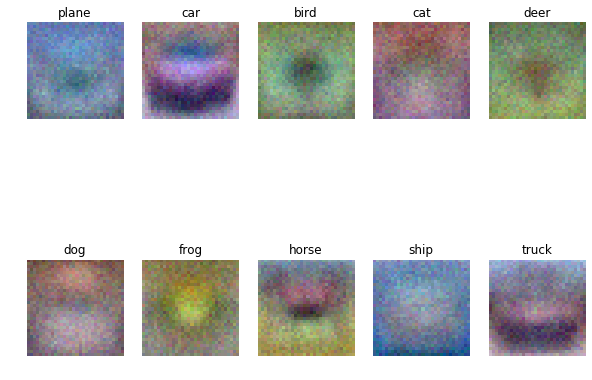

In [0]:
w = best_sfmx.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

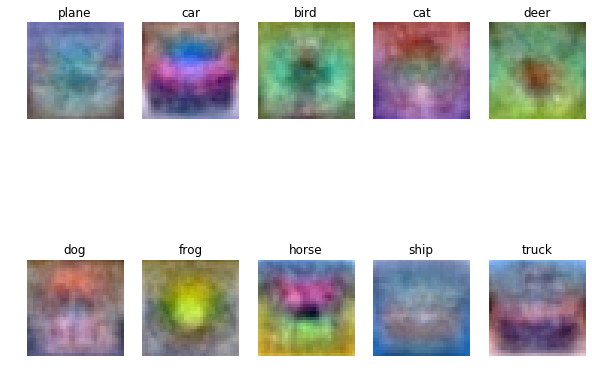

In [0]:
# visualize the learned weights for each class.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i] - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])